In [2]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
sys.path.append('../utils/')

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt


In [15]:
from recurrent_inference import rim, ConvRIM3D
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell
from tensorflow.python.keras.layers import LSTMCell, LSTM, Dense



In [5]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 1000
size_test = 500

In [6]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma, (2,))

def generate_A():
    D = np.diag(np.random.choice([-1,1], (2,)) * np.random.uniform(0.25, 1, (2,)))
    theta = np.random.uniform(0,2*np.pi)
    P = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.linalg.inv(P).dot(D).dot(P)

def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)

In [213]:
A_train = np.array([generate_A() for i in range(size_train)]).astype(float32)
sigma_train = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_train)]).astype(float32)

X_train = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_train)]).astype(float32)
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)]).astype(float32)
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)]).astype(float32)
X0_train = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_train]).astype(float32)

In [214]:
A_test = np.array([generate_A() for i in range(size_test)]).astype(float32)
sigma_test = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_test)]).astype(float32)

X_test = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_test)]).astype(float32)
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)]).astype(float32)
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)]).astype(float32)
X0_test = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_test]).astype(float32)

# GD

In [215]:
lr = 0.1

list_xt_gd = []
for (x0, y, A) in zip(X0_test, Y_test, A_test):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

In [216]:

extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])
XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)
Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])


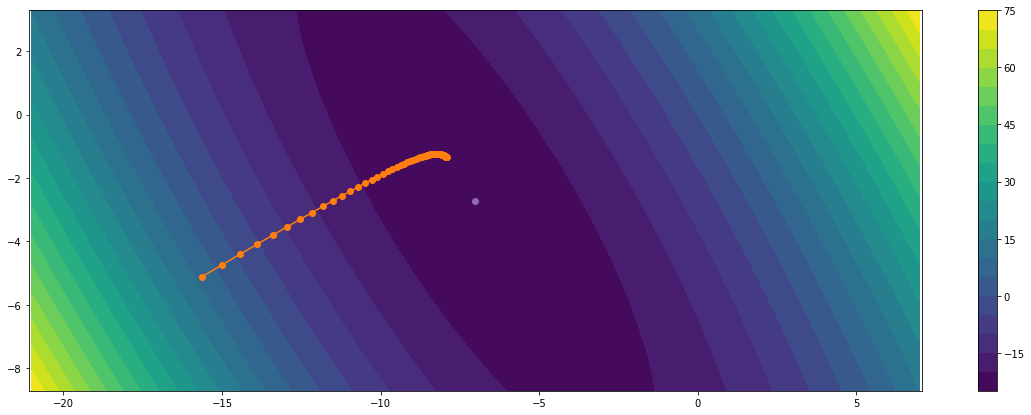

In [217]:
i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

# Code RIM

In [218]:


@tf.function
def tf_fwdmodel(x, A):
    return tf.matmul(x, A)


@tf.function(
    input_signature=[tf.TensorSpec(shape=(None, 2), dtype=tf.float32), 
                    tf.TensorSpec(shape=(None, 2), dtype=tf.float32), 
                    tf.TensorSpec(shape=(None, 2, 2), dtype=tf.float32)])
def tf_loss(x, y, A):
    print('loss')
    x_t, y_t = tf.expand_dims(x, 1), tf.expand_dims(y, 1)
    term1 = tf.vectorized_map(lambda a: 0.5 * tf.matmul(a[0], tf.matmul(tf.transpose(a[1]), tf.matmul(a[1], tf.transpose(a[0])))),
                      (x_t, A))
    term2 = tf.vectorized_map(lambda a: - tf.matmul(a[1], tf.matmul(a[2], tf.transpose(a[0]))), 
                      (x_t, y_t, A))
    return tf.reduce_sum(term1 + term2)


@tf.function
def tf_loss_grad(x, y, A):
    print('grad')
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = tf_loss(x, y, A)
    grad = tape.gradient(loss, x)
    return grad





In [321]:
class myRIM(tf.keras.Model):

    def __init__(self, cell, output_layer, niter):
        super(myRIM, self).__init__()
        self.cell = cell
        self.output_layer = output_layer
        self.niter = niter

            
    def call(self, x_init, y, grad_fn, grad_args, initstates = None, return_steps=False):
        
        outputs_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        states_ta = tf.TensorArray(size=self.niter+1, dtype=tf.float32)
        
        if initstates is None: 
            initstates = [tf.zeros([y.shape[0], self.cell.output_size]), tf.zeros([y.shape[0], self.cell.output_size])]
    
        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        curr_pos = x_init
        
        def body(i, pos, states):  
            gradient = grad_fn(pos, y, *grad_args)
#             cell_state_concat = tf.concat([y, gradient], axis=-1)
            cell_state_concat = tf.concat([pos, gradient], axis=-1)
            delta_pos, new_state = self.cell(cell_state_concat, states)
            delta_pos = self.output_layer(delta_pos)
            new_pos = pos + delta_pos
            return i +1 , new_pos, new_state
        
        while tf.less(i, tf.constant(self.niter)):
            outputs_ta = outputs_ta.write(i, curr_pos)
            states_ta = states_ta.write(i, curr_state)
            i, curr_pos, curr_state =  body(i, curr_pos, curr_state)
        outputs_ta = outputs_ta.write(i, curr_pos)
        states_ta = states_ta.write(i, curr_state)
        return outputs_ta.stack(), states_ta.stack()


In [322]:
del cell, testrim

In [345]:
cellsize = 8
cell = LSTMCell(cellsize)
cell.build(input_shape=[None, 4])
# testrim = myRIM(cell,  niter=10)

output_layer = Dense(2, trainable=False)
# output_layer = Dense(2, trainable=False, use_bias=False, kernel_initializer=tf.ones)
output_layer.build(input_shape=(None, cellsize))
testrim = myRIM(cell, output_layer, niter=time_max_rim)


idx = np.random.randint(0, X_train.shape[0], 10)
xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
out, states = testrim(x_init=tf.constant(xx), y=tf.constant(yy), grad_fn=tf_loss_grad, grad_args=[tf.constant(A)])



In [346]:
# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


# @tf.function
def rim_train(x_true, x_init, y, A):
    with tf.GradientTape() as tape:
        x_pred, states = testrim(x_init, y, tf_loss_grad, [A])
        loss = tf.reduce_mean(tf.square((x_true- x_pred)))
    gradients = tape.gradient(loss, testrim.trainable_variables)
    opt.apply_gradients(zip(gradients, testrim.trainable_variables))
    return loss
    
    

In [347]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

# with tf.GradientTape() as tape:
#     tape.watch(testrim.trainable_variables)
#     out, states = testrim(tf.constant(xinit),  tf.constant(yy), grad, [tf.constant(A)])
#     testloss = tf.reduce_sum((out - tf.constant(xx)**2))
# testgrads  = tape.gradient(testloss, testrim.trainable_variables)
    


In [348]:
losses = []
for i in range(200):
    idx = np.random.randint(0, X_train.shape[0], 16)
    xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
    losses.append(rim_train(tf.constant(xx), tf.constant(xinit), tf.constant(yy), tf.constant(A)).numpy())
#     testrim(tf.constant(xinit), tf.constant(yy), grad, [tf.constant(A)])
#     print(testrim.cell.kernel)    

[]

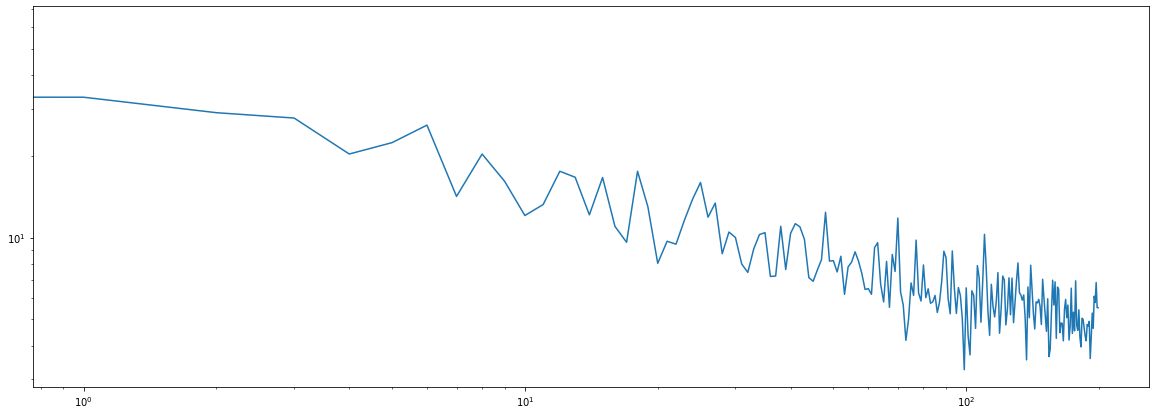

In [349]:
plt.plot(losses)
plt.loglog()

In [350]:
idx = np.random.randint(0, X_train.shape[0], 32)
xinit, xx, yy, A = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx]
out = testrim(tf.constant(xinit), tf.constant(yy), tf_loss_grad, [tf.constant(A)])
pred = out[1].numpy()
cstate = out[1][:, 0]

### Test

In [351]:
idx = np.random.randint(0, X_train.shape[0], 32)
xinit, xx, yy, A = X0_test.astype(float32), X_test.astype(float32), Y_test.astype(float32), A_test
out = testrim(tf.constant(xinit), tf.constant(yy), tf_loss_grad, [tf.constant(A)])
pred = out[0].numpy()
cstate = out[1][:, 0]

# list_xt_rim, losses = [], []
# for (x0, y, x, A) in zip(X0_test, Y_test, X_test, A_test):
#     list_xt, loss = rim.forward_sequence(x0, y, x, A, "test")
#     list_xt_rim.append(list_xt)
#     losses.append(loss.data.numpy()[0])
# list_xt_rim = np.array(list_xt_rim)
# losses = np.array(losses)



In [352]:
list_xt_rim = np.array([pred[:, i, :] for i in range(pred.shape[1])])
testlossrim = ((X_test - list_xt_rim[:, -1, :])**2).sum(axis=-1)**0.5
testlossgd = ((X_test - list_xt_gd[:, -1, :])**2).sum(axis=-1)**0.5

In [1]:
i_example = np.random.randint(pred.shape[1])
print(i_example)

print("RIM Loss: {0:5f}".format(float(testlossrim[i_example])))
print("GD Loss: {0:5f}".format(float(testlossgd[i_example])))

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

# Plot the loss
plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar();
plt.scatter(X_test[i_example][0], X_test[i_example][1], c=colormap[2], zorder=10, label="True x")
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4], zorder=10, label="Minimum")

# Plot the RIM results
plt.plot(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9])
plt.scatter(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9], label="RIM")
plt.scatter(list_xt_rim[i_example,-1,0], list_xt_rim[i_example,-1,1], color=colormap[7], label="RIM", marker='s', s=100)

# Plot the GD results
plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1], label="GD")

plt.xlabel("$x_0$", size=15)
plt.ylabel("$x_1$", size=15)
plt.title("Comparison of RIM and gradient descent", size=15)
plt.legend()
# plt.savefig("screenshots/toy-model-1-sample.png")

NameError: name 'np' is not defined

(array([148., 147.,  84.,  43.,  36.,  24.,   8.,   4.,   3.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <a list of 10 Patch objects>)

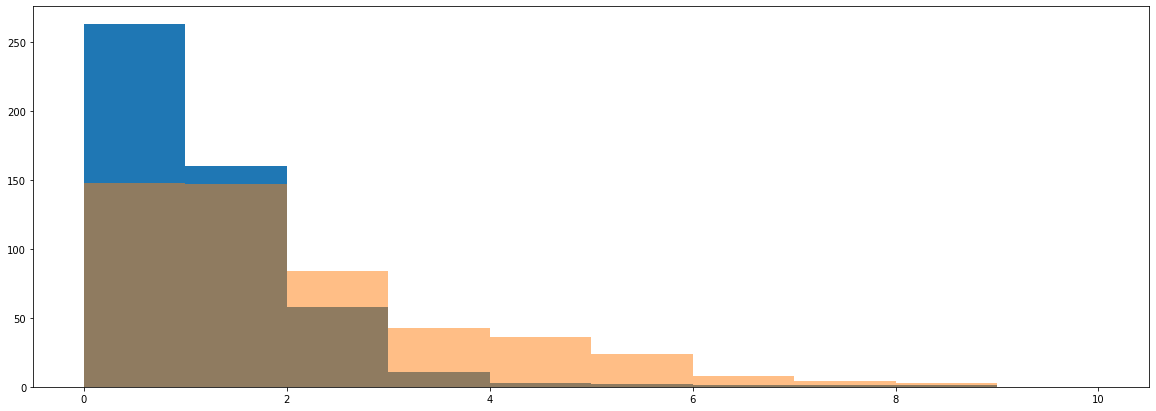

In [354]:
plt.hist(testlossrim, range=(0, 10))
plt.hist(testlossgd, alpha=0.5, range=(0, 10))


In [355]:


dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_min_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_min_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to min x with RIM: ", mean_rim)
print("Average distance to min x with GD: ", mean_gd)

print("STD distance to min x with RIM: ", std_rim)
print("STD distance to min x with GD: ", std_gd)


Average distance to min x with RIM:  0.783723
Average distance to min x with GD:  1.6700162
STD distance to min x with RIM:  0.77863693
STD distance to min x with GD:  1.6523387


In [356]:

binwidth = 0.5

dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to true x with RIM: ", mean_rim)
print("Average distance to true x with GD: ", mean_gd)

print("STD distance to true x with RIM: ", std_rim)
print("STD distance to true x with GD: ", std_gd)

Average distance to true x with RIM:  1.1937134
Average distance to true x with GD:  2.1779253
STD distance to true x with RIM:  0.9846606
STD distance to true x with GD:  1.8039178
